In [1]:
import scipy as sp
import numpy as np
import numpy.random as rd
import scipy.linalg as LA
import scipy.sparse.linalg as sLA
import time

from RMG import RMG

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns
sns.set(style='darkgrid')

In [3]:
def lambda_funct (evlA,evlB,T):
    tt = np.all(evlA==0) or np.all(evlB==0)
    if T!=0:
        return evlA+sp.special.lambertw(evlB*T*np.exp(-evlA*T))/T
    elif T==0 and tt:
        return (evlA+evlB)

In [4]:
#EIGENVALUES COMPUTATION
def comp_eig(M, sparse='no',symm='no'):
    evl=0
    if symm == 'no':
        if sparse =='no':
            evl = LA.eigvals(M)
        if sparse =='yes':
            mm = sp.sparse.csr_matrix(M)
            evl = sLA.eigs(mm,k=1,which='LR',return_eigenvectors=False)
    if symm == 'yes':
        if sparse =='no':
            evl = LA.eigvalsh(M)
        if sparse =='yes':
            mm = sp.sparse.csr_matrix(M)
            evl = sLA.eigsh(mm,k=1,which='LA',return_eigenvectors=False)
    return evl

def comp_eig_delay(A, B, T, symm='no'):
    if np.all(A == 0):
        evlB = comp_eig(B, sparse='no',symm=symm)
        return lambda_funct (0,evlB,T)
    else:
        evlA = comp_eig(A, sparse='no',symm=symm)
        evlB = comp_eig(B, sparse='no',symm=symm)
        return lambda_funct (evlA,evlB,T)

In [5]:
color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

# Eigenvalues of a generic DDE

We consider the differential equation $\quad\dfrac{d\vec{x}}{dt} = f\big(\vec{x}(t),\vec{x}(t-T)\big)\quad$ which can be linearized near the equilibrium $x^*$, given by: $f(x^*,x^*)=0$ obtaining the linear system of DDEs:
$$\dfrac{d\vec{y}}{dt} = \ A\cdot\vec{y}(t)\ +\ B\cdot\vec{y}(t-T)\qquad\text{with:}\qquad y=x-x^*$$

Here A and B are the Jacobian matrices, we can substitute them with Random Matrices and then study the system using the Random Matrix Theory.


What we call eigevalues are the solutions of the characteristic equation obtained from the DDE by using the **Linear Stability Analysis**, i.e. by substituting solutions of the form: $\vec{x}(t) = e^{\lambda t}\vec{v}$ in the DDE obtaining a characteristic equation for $\lambda$:

$$\quad det\big(A+B e^{-\lambda T}-\lambda\mathbb{1}\big)=0$$

The easier method to find the eigenvalues is by considering commuting matrices $[A,B]=0$ which can be simultaneously diagonalized by the same eigevectors giving eigenvalues: $a,b$. The characteristic equation then can be solved using the Lambert W function obtaining:

$$\lambda = a+\dfrac{1}{T}W \big(bT e^{-a T}\big) \qquad\quad\text{with:}\quad W(z)\in \mathbb{C}\ :\ W(z)e^{W(z)} = z \in \mathbb{C}$$

## Case $A=0$, $\quad B= R.M.$ with $\quad S=1000, C=0.4, \sigma=0.05*f$

In [22]:
S = 1000       #species - shape matrix
C = 0.4        #connectance
d = 1          #diagonal elements
mu = 0         #mean random coefficients
sigma = 0.05    #sigma random coefficients
Tvec = [0.2,0.5,1.,2.]

complexity = sigma*np.sqrt(S*C)
Class = RMG(S,C,d,mu,sigma)

In [23]:
#circle
theta = np.linspace(0, 2*np.pi, 1000)
r = complexity
x = r*np.cos(theta)
y = r*np.sin(theta)
#ellipse
E = np.sqrt(2/np.pi)*sigma
a = complexity*(1+(E/sigma)**2)
b = complexity*(1-(E/sigma)**2)
c = np.sqrt(a**2-b**2)
r1 = b/np.sqrt(1-(c/a*np.cos(theta))**2)
x1 = r1*np.cos(theta)
y1 = r1*np.sin(theta)

### Center in the origin (d=0)

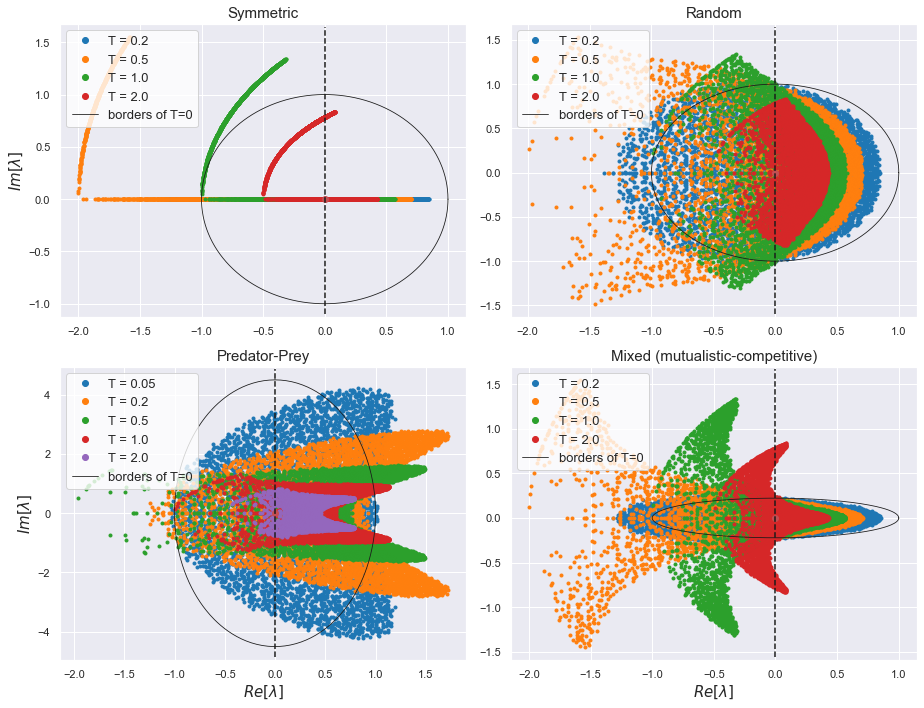

In [24]:
Class.d = 0
num=4

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
Class.sym_matrix()
for j,T in enumerate(Tvec):
    evl  = comp_eig_delay(0,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.sym_matrix()
        evl  = comp_eig_delay(0,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d,0,'or')
plt.plot(x-Class.d,y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,2)
Class.sigma = sigma
Class.ran_matrix()
for j,T in enumerate(Tvec):
    evl  = comp_eig_delay(0,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.ran_matrix()
        evl  = comp_eig_delay(0,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])       
plt.plot(-Class.d,0,'or')
plt.plot(x-Class.d,y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,3)
Class.sigma = sigma*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,T in enumerate([0.05]+Tvec):
    evl  = comp_eig_delay(0,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.pp_matrix()
        evl  = comp_eig_delay(0,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d,0,'or')
plt.plot(y1*(np.pi/(np.pi-2))-Class.d,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for j,T in enumerate(Tvec):
    evl  = comp_eig_delay(0,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.mix_matrix()
        evl  = comp_eig_delay(0,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d,0,'or')
plt.plot(x1*(np.pi/(np.pi+2))-Class.d,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

fig.tight_layout()
plt.show(fig)

### Center in $(-1,0)$: $d_B=1$

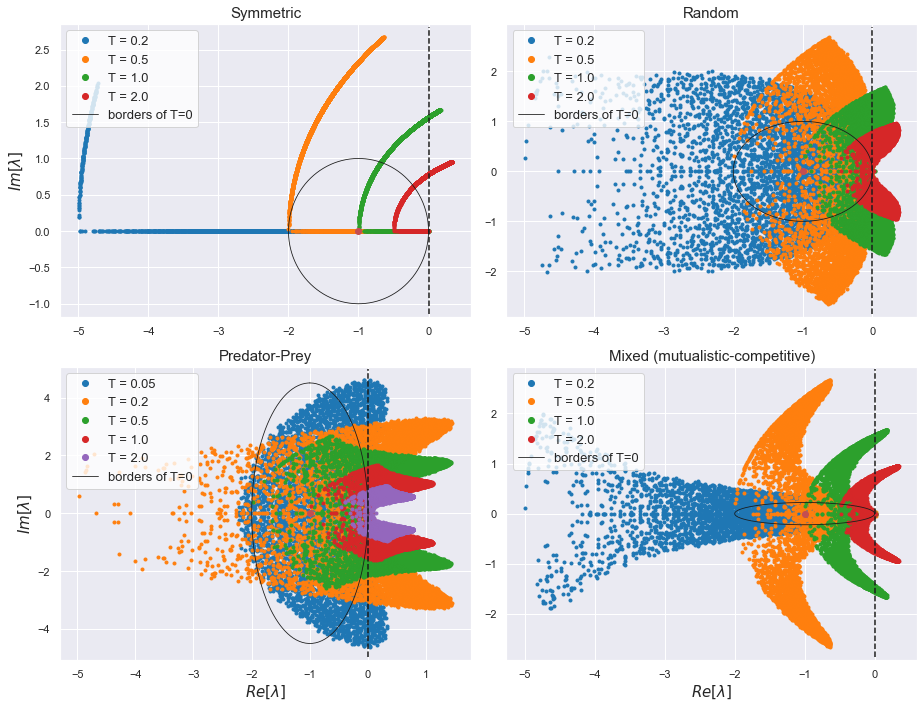

In [25]:
Class.d = 1
num=4

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
Class.sym_matrix()
for j,T in enumerate(Tvec):
    evl  = comp_eig_delay(0,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.sym_matrix()
        evl  = comp_eig_delay(0,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d,0,'or')
plt.plot(x-Class.d,y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,2)
Class.sigma = sigma
Class.ran_matrix()
for j,T in enumerate(Tvec):
    evl  = comp_eig_delay(0,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.ran_matrix()
        evl  = comp_eig_delay(0,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])       
plt.plot(-Class.d,0,'or')
plt.plot(x-Class.d,y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,3)
Class.sigma = sigma*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,T in enumerate([0.05]+Tvec):
    evl  = comp_eig_delay(0,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.pp_matrix()
        evl  = comp_eig_delay(0,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d,0,'or')
plt.plot(y1*(np.pi/(np.pi-2))-Class.d,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for j,T in enumerate(Tvec):
    evl  = comp_eig_delay(0,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.mix_matrix()
        evl  = comp_eig_delay(0,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d,0,'or')
plt.plot(x1*(np.pi/(np.pi+2))-Class.d,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

fig.tight_layout()
plt.show(fig)

## Case $A = -\mathbb{1}$, $\quad B= R.M.$ with $\quad S=1000, C=0.4, \sigma=0.05*f$

### Center in $(-1,0)$: $d_B=0$

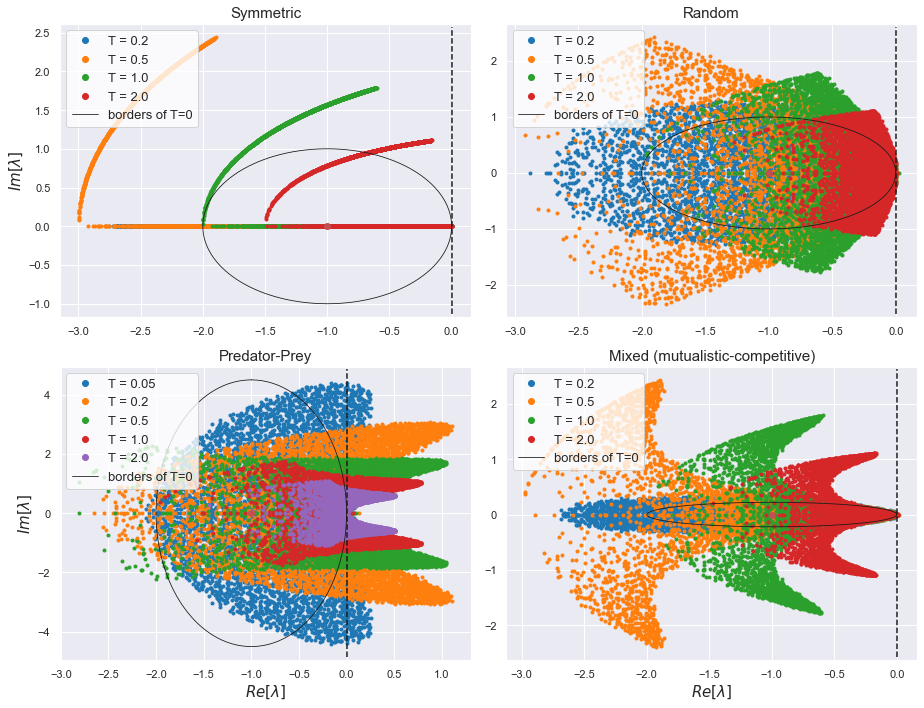

In [26]:
Class.d = 0
a=-1
num=4

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
Class.sym_matrix()
for j,T in enumerate(Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.sym_matrix()
        evl  = comp_eig_delay(A,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(x-Class.d+a,y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,2)
Class.sigma = sigma
Class.ran_matrix()
for j,T in enumerate(Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.ran_matrix()
        evl  = comp_eig_delay(A,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])       
plt.plot(-Class.d+a,0,'or')
plt.plot(x-Class.d+a,y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,3)
Class.sigma = sigma*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,T in enumerate([0.05]+Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.pp_matrix()
        evl  = comp_eig_delay(A,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(y1*(np.pi/(np.pi-2))-Class.d+a,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for j,T in enumerate(Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.mix_matrix()
        evl  = comp_eig_delay(A,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(x1*(np.pi/(np.pi+2))-Class.d+a,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

fig.tight_layout()
plt.show(fig)

### Center in $(-2,0)$: $d_B=1$ (and $\sigma_B = 0.1*f$ to have transition)

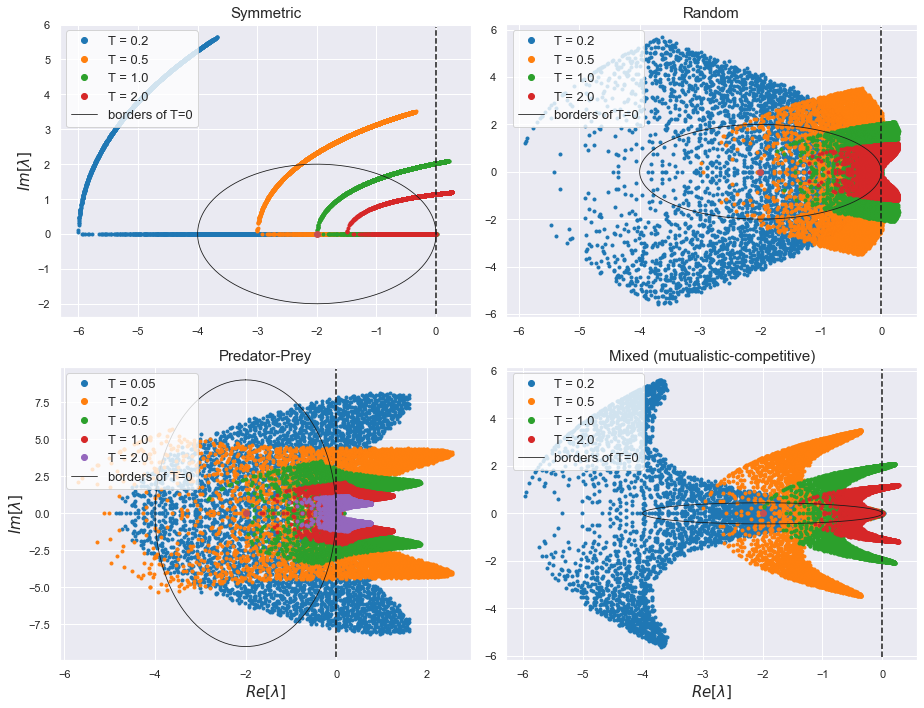

In [27]:
Class.d = 1
sigma = 0.1
a=-1
num=4

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
Class.sym_matrix()
for j,T in enumerate(Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.sym_matrix()
        evl  = comp_eig_delay(A,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(2*x-Class.d+a,2*y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,2)
Class.sigma = sigma
Class.ran_matrix()
for j,T in enumerate(Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.ran_matrix()
        evl  = comp_eig_delay(A,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])       
plt.plot(-Class.d+a,0,'or')
plt.plot(2*x-Class.d+a,2*y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,3)
Class.sigma = sigma*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,T in enumerate([0.05]+Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.pp_matrix()
        evl  = comp_eig_delay(A,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(2*y1*(np.pi/(np.pi-2))-Class.d+a,2*x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for j,T in enumerate(Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.mix_matrix()
        evl  = comp_eig_delay(A,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(2*x1*(np.pi/(np.pi+2))-Class.d+a,2*y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

fig.tight_layout()
plt.show(fig)

## Case $B = -\mathbb{1}$, $\quad A= R.M.$ with $\quad S=1000, C=0.4, \sigma=0.05*f$

### Center in $(-1,0)$: $d_A=0$

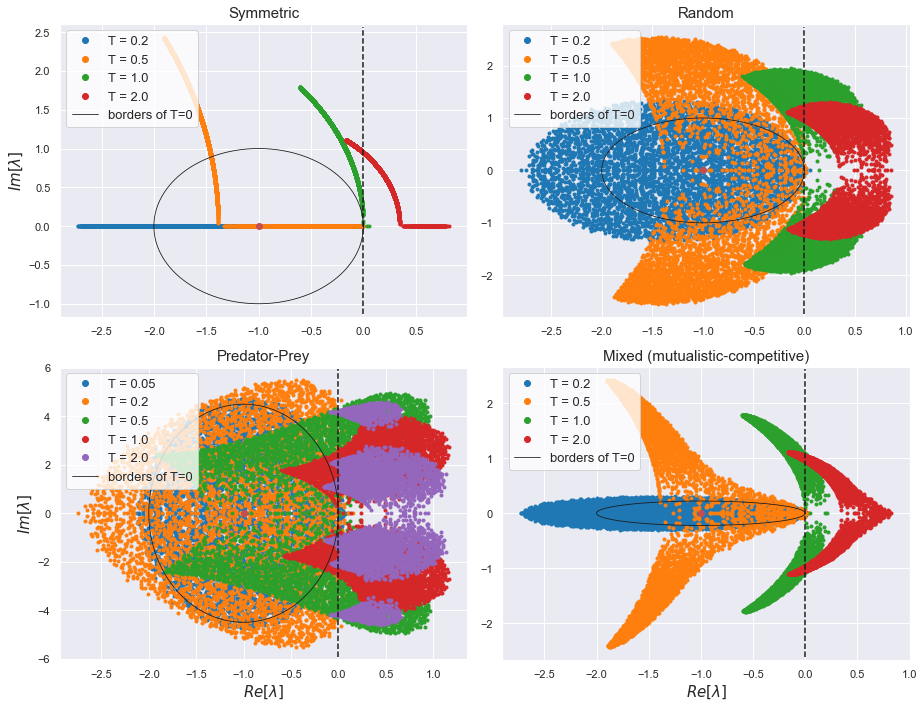

In [28]:
Class.d = 0
sigma = 0.05
a=-1
num=4

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
Class.sym_matrix()
for j,T in enumerate(Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(Class.M,A,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.sym_matrix()
        evl  = comp_eig_delay(Class.M,A,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(x-Class.d+a,y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,2)
Class.sigma = sigma
Class.ran_matrix()
for j,T in enumerate(Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(Class.M,A,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.ran_matrix()
        evl  = comp_eig_delay(Class.M,A,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])       
plt.plot(-Class.d+a,0,'or')
plt.plot(x-Class.d+a,y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,3)
Class.sigma = sigma*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,T in enumerate([0.05]+Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(Class.M,A,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.pp_matrix()
        evl  = comp_eig_delay(Class.M,A,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(y1*(np.pi/(np.pi-2))-Class.d+a,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for j,T in enumerate(Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(Class.M,A,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.mix_matrix()
        evl  = comp_eig_delay(Class.M,A,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(x1*(np.pi/(np.pi+2))-Class.d+a,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

fig.tight_layout()
plt.show(fig)

### Center in $(-2,0)$: $d_A=1$ (and $\sigma_A = 0.1*f$ to have transition)

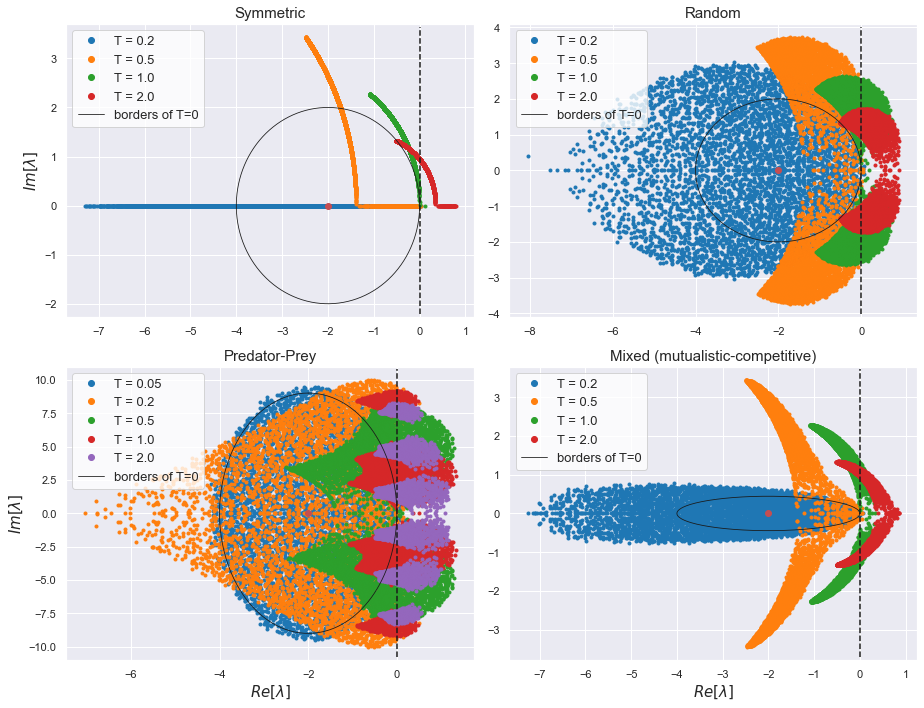

In [29]:
Class.d = 1
sigma = 0.1
a=-1
num=4

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
Class.sym_matrix()
for j,T in enumerate(Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(Class.M,A,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.sym_matrix()
        evl  = comp_eig_delay(Class.M,A,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(2*x-Class.d+a,2*y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,2)
Class.sigma = sigma
Class.ran_matrix()
for j,T in enumerate(Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(Class.M,A,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.ran_matrix()
        evl  = comp_eig_delay(Class.M,A,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])       
plt.plot(-Class.d+a,0,'or')
plt.plot(2*x-Class.d+a,2*y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,3)
Class.sigma = sigma*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,T in enumerate([0.05]+Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(Class.M,A,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.pp_matrix()
        evl  = comp_eig_delay(Class.M,A,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(2*y1*(np.pi/(np.pi-2))-Class.d+a,2*x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for j,T in enumerate(Tvec):
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(Class.M,A,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.mix_matrix()
        evl  = comp_eig_delay(Class.M,A,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(2*x1*(np.pi/(np.pi+2))-Class.d+a,2*y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

fig.tight_layout()
plt.show(fig)

## Both $A, B = R.M.$ (perturbation method)
Solving the characteristic equation $\quad \big(A+B e^{-\lambda T}-\lambda\mathbb{1}\big)\vec{v}=0\quad$ is an impossible task when the matrices $A,B$ are large and don't commute.

Therefore, to compute the eigenvalues, we need to use a different approach and introduce the perturbation method in the following form:

$$A = D +\varepsilon A^*,\quad\text{with}\quad [D,B] = 0,\quad [A^*,B]\neq 0\quad \text{and}\quad 0<\varepsilon<<1;\quad ||A^*||\lesssim ||B$$

Then we assume: $\quad\lambda = \lambda_0+\varepsilon\lambda_1+\varepsilon^2\lambda_2+\dots\quad$ and $\quad\vec{v} = \vec{v}_0+\varepsilon\vec{v}_1+\varepsilon^2\vec{v}_2+\dots$


Substituting in the characteristic equation we obtain the operators:

$$\begin{cases}
L_0 = D+B e^{-\lambda_0 T}-\lambda_0\mathbb{1}\\
L_1 = A^*-B e^{-\lambda_0 T}\lambda_1 T-\lambda_1\mathbb{1}
\end{cases}$$

And finally the following solutions:

**First order $O(1)$:** $\quad L_0\vec{v}_0 = 0\quad$ which gives: $\quad\lambda_0 = d+\dfrac{1}{T}W \big(bT e^{-d T}\big)$ for $(d,b)$ eigenvalues of $(D,B)$

**Second order $O(\varepsilon)$:** $\quad L_0\vec{v}_1+ L_1\vec{v}_0 = 0\quad$ which gives $\quad\lambda_1 = \dfrac{\vec{w}_0^T A^* \vec{v}_0}{\vec{w}_0^T\vec{v}_0}\dfrac{1}{1+T(\lambda_0-d)}$

We obtained the last equation for $\lambda_1$ by multiplying the first by $\vec{w}_0$ which is defined as the left eigenvector of $L_0$, i.e. $\quad\vec{w}_0^T L_0=0\quad$ and using the facts that: $\quad\vec{w}_0^T B=b\vec{w}_0^T\quad$ and $\quad bTe^{-\lambda_0T} = T(\lambda_0-d)$


# Fill with explanation

### $B$ has $S=1000, C=0.4, \sigma =0.1*f, d_B=1$ 

### $A$ is the same but has $\sigma_A =\varepsilon\sigma_B$ thus $A$ can be written as $A = D +\varepsilon A^*$ with $D=-d_A\mathbb{1}$, $A^*\sim B$ and $\varepsilon=1/10$

In [30]:
def eig_perturb (D,A,B,T,epsi,symm='no'):
    evlD = comp_eig(D,symm=symm)
    evlB, evec = LA.eig(B)
    evlBT, evecT_old = LA.eig(B.T)
    #Reorder left eigenvectors
    evecT = np.zeros((evecT_old.shape[0],evecT_old.shape[1]),dtype=complex)
    bb=0
    for i,elem in enumerate(evlBT):
        aa = abs(evlB-elem)
        ind = min(range(len(aa)), key=aa.__getitem__)
        evecT[:,ind] = evecT_old[:,i]
        bb += ind
    if int(bb)!=int(len(evlB)*(len(evlB)-1)/2):
        print('ERROR',bb,int(len(evlB)*(len(evlB)-1)/2))

    lamb0 = lambda_funct (evlD,evlB,T)
    rho = np.sum(evecT*(A@evec), axis=0)/np.sum((evecT*evec), axis=0)
    lamb1 = rho*1/(1+T*(lamb0-evlD))
    
    return lamb0 + epsi*lamb1

In [37]:
S = 1000       #species - shape matrix
C = 0.4        #connectance
d = 1          #diagonal elements
mu = 0         #mean random coefficients
sigma = 0.1    #sigma random coefficients

complexity = sigma*np.sqrt(S*C)
Class = RMG(S,C,d,mu,sigma)

In [38]:
#circle
theta = np.linspace(0, 2*np.pi, 1000)
r = complexity
x = r*np.cos(theta)
y = r*np.sin(theta)
#ellipse
E = np.sqrt(2/np.pi)*sigma
a = complexity*(1+(E/sigma)**2)
b = complexity*(1-(E/sigma)**2)
c = np.sqrt(a**2-b**2)
r1 = b/np.sqrt(1-(c/a*np.cos(theta))**2)
x1 = r1*np.cos(theta)
y1 = r1*np.sin(theta)

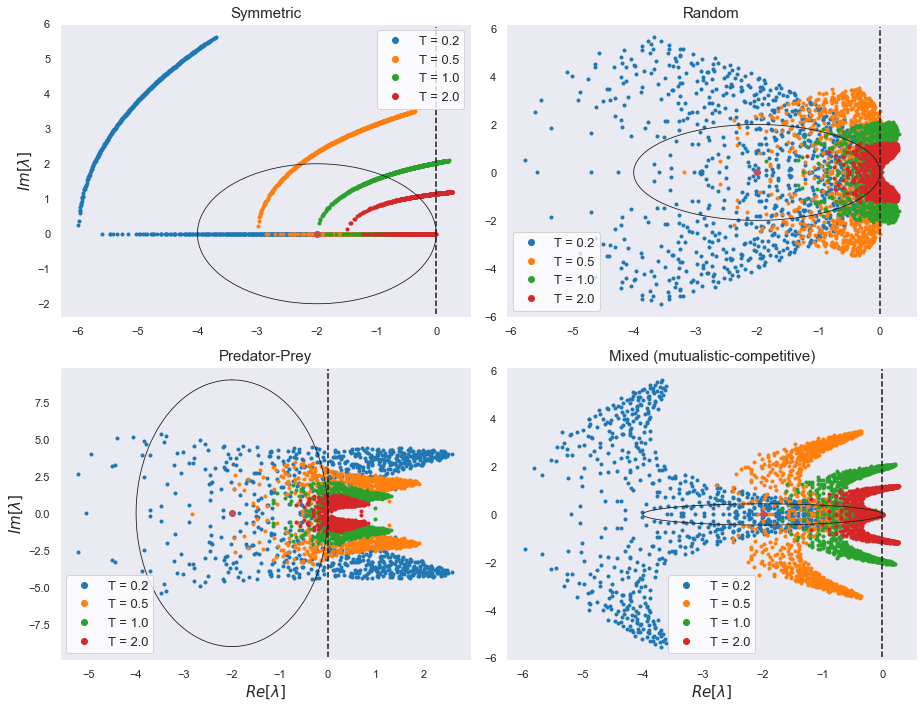

In [39]:
Tvec = [0.2,0.5,1.,2.]
da, db = 0, 1
epsi = 0.1
D = -np.eye(Class.S)
c = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
Class.d = da
Class.sym_matrix()
A = Class.M
Class.d = db
Class.sym_matrix()
B = Class.M
for j,T in enumerate(Tvec):
    evl = eig_perturb (D,A,B,T,epsi)
    plt.plot(evl.real, evl.imag,'.', color=color[j], label=f'T = {T}')
plt.plot(-2,0,'or')
plt.plot(x-2,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.grid()
plt.legend(fontsize=13,markerscale=2,facecolor='w')

plt.subplot(2,2,2)
Class.sigma = sigma
Class.d = da
Class.ran_matrix()
A = Class.M
Class.d = db
Class.ran_matrix()
B = Class.M
for j,T in enumerate(Tvec):
    evl = eig_perturb (D,A,B,T,epsi)
    plt.plot(evl.real, evl.imag,'.', color=color[j], label=f'T = {T}')
plt.plot(-2,0,'or')
plt.plot(x-2,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.grid()
plt.legend(fontsize=13,markerscale=2,facecolor='w')

plt.subplot(2,2,3)
Class.sigma = sigma*(np.pi/(np.pi-2))
Class.d = da
Class.pp_matrix()
A = Class.M
Class.d = db
Class.pp_matrix()
B = Class.M
for j,T in enumerate(Tvec):
    evl = eig_perturb (D,A,B,T,epsi)
    plt.plot(evl.real, evl.imag,'.', color=color[j], label=f'T = {T}')
plt.plot(-2,0,'or')
plt.plot(y1*(np.pi/(np.pi-2))-2,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.grid()
plt.legend(fontsize=13,markerscale=2,facecolor='w')

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.d = da
Class.mix_matrix()
A = Class.M
Class.d = db
Class.mix_matrix()
B = Class.M
for j,T in enumerate(Tvec):
    evl = eig_perturb (D,A,B,T,epsi)
    plt.plot(evl.real, evl.imag,'.', color=color[j], label=f'T = {T}')
plt.plot(-2,0,'or')
plt.plot(x1*(np.pi/(np.pi+2))-2,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.grid()
plt.legend(fontsize=13,markerscale=2,facecolor='w')

fig.tight_layout()
plt.show(fig)

# Eigenvalues for Delay dependent matrices

$$\lambda\vec{v} = \big(A+e^{-c T}\cdot B e^{-\lambda T}\big)\vec{v}$$

In [53]:
S = 1000       #species - shape matrix
C = 0.4        #connectance
d = 1          #diagonal elements
mu = 0         #mean random coefficients
sigma = 0.1    #sigma random coefficients

complexity = sigma*np.sqrt(S*C)
Class = RMG(S,C,d,mu,sigma)

In [54]:
#circle
theta = np.linspace(0, 2*np.pi, 1000)
r = complexity
x = r*np.cos(theta)
y = r*np.sin(theta)
#ellipse
E = np.sqrt(2/np.pi)*sigma
a = complexity*(1+(E/sigma)**2)
b = complexity*(1-(E/sigma)**2)
c = np.sqrt(a**2-b**2)
r1 = b/np.sqrt(1-(c/a*np.cos(theta))**2)
x1 = r1*np.cos(theta)
y1 = r1*np.sin(theta)

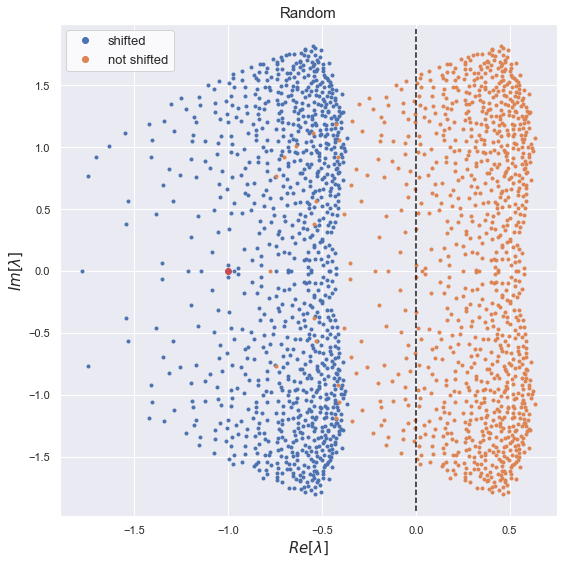

In [41]:
Tvec = [1.]
a = -1.

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(8,8)

Class.sigma = sigma
Class.ran_matrix()
for T in Tvec:
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl = comp_eig_delay(A, b*Class.M, T, symm='no')
    plt.plot(evl.real, evl.imag,'.',label=f'shifted')
    evl = comp_eig_delay(0, Class.M, T, symm='no')
    plt.plot(evl.real, evl.imag,'.',label=f'not shifted')
plt.plot(-1,0,'or')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Random",fontsize=15)
plt.legend(fontsize=13,markerscale=2,facecolor='w')

fig.tight_layout()
plt.show(fig)

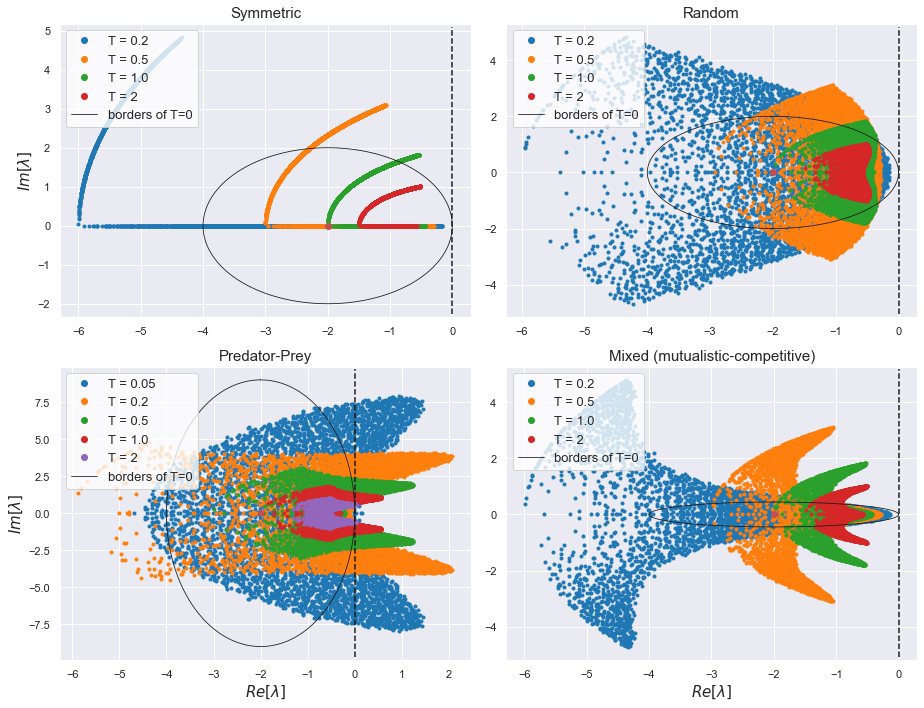

In [55]:
Tvec = [0.2,0.5,1.,2]
Class.d = 1
sigma = 0.1
a=-1
num=4

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
Class.sym_matrix()
for j,T in enumerate(Tvec):
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,b*Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.sym_matrix()
        evl  = comp_eig_delay(A,b*Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(x-Class.d+a,y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,2)
Class.sigma = sigma
Class.ran_matrix()
for j,T in enumerate(Tvec):
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,b*Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.ran_matrix()
        evl  = comp_eig_delay(A,b*Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])       
plt.plot(-Class.d+a,0,'or')
plt.plot(x-Class.d+a,y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,3)
Class.sigma = sigma*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,T in enumerate([0.05]+Tvec):
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,b*Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.pp_matrix()
        evl  = comp_eig_delay(A,b*Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(y1*(np.pi/(np.pi-2))-Class.d+a,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for j,T in enumerate(Tvec):
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,b*Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.mix_matrix()
        evl  = comp_eig_delay(A,b*Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(x1*(np.pi/(np.pi+2))-Class.d+a,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

fig.tight_layout()
plt.show(fig)

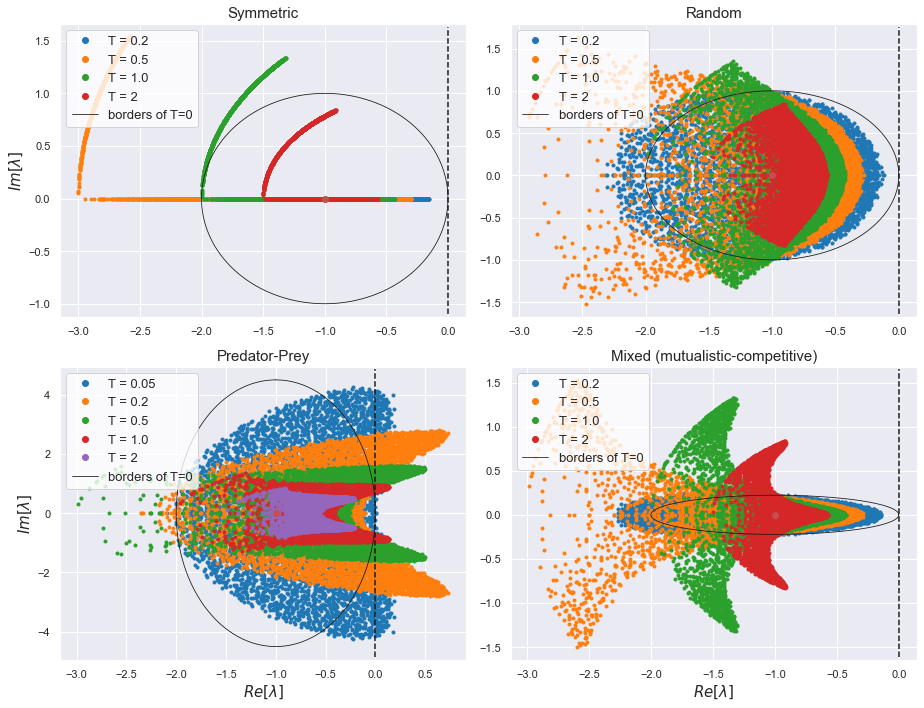

In [56]:
Tvec = [0.2,0.5,1.,2]
Class.d = 0
sigma = 0.05
a=-1
num=4

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
Class.sym_matrix()
for j,T in enumerate(Tvec):
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,b*Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.sym_matrix()
        evl  = comp_eig_delay(A,b*Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(1/2*x-Class.d+a,1/2*y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,2)
Class.sigma = sigma
Class.ran_matrix()
for j,T in enumerate(Tvec):
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,b*Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.ran_matrix()
        evl  = comp_eig_delay(A,b*Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])       
plt.plot(-Class.d+a,0,'or')
plt.plot(1/2*x-Class.d+a,1/2*y,'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,3)
Class.sigma = sigma*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,T in enumerate([0.05]+Tvec):
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,b*Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.pp_matrix()
        evl  = comp_eig_delay(A,b*Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(1/2*y1*(np.pi/(np.pi-2))-Class.d+a,1/2*x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for j,T in enumerate(Tvec):
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl  = comp_eig_delay(A,b*Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.mix_matrix()
        evl  = comp_eig_delay(A,b*Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
plt.plot(-Class.d+a,0,'or')
plt.plot(1/2*x1*(np.pi/(np.pi+2))-Class.d+a,1/2*y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8,label='borders of T=0')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

fig.tight_layout()
plt.show(fig)

### Comparison different f(T)

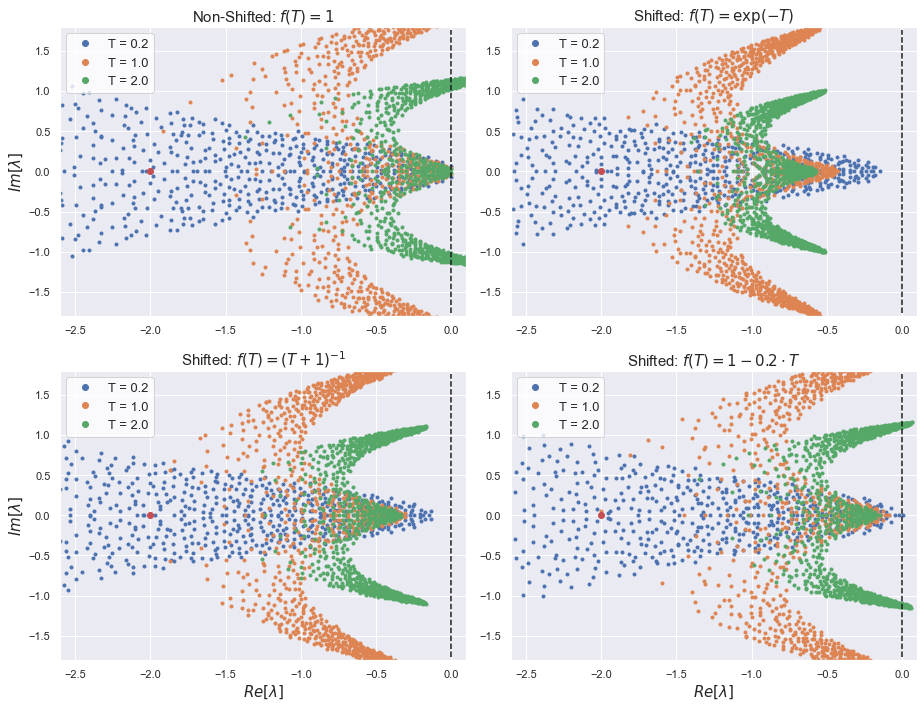

In [43]:
Class.d = 1
sigma = 0.1
a=-1

Tvec = [0.2,1.,2.]

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for T in Tvec:
    A = a*np.eye(Class.S)
    evl = comp_eig_delay(A, Class.M, T, symm='no')
    plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
plt.plot(-2,0,'or')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title(r"Non-Shifted: $f(T) = 1$",fontsize=15)
plt.ylim(-1.8,1.8)
plt.xlim(-2.6,0.1)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,2)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for T in Tvec:
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl = comp_eig_delay(A, b*Class.M, T, symm='no')
    plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
plt.plot(-2,0,'or')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title(r"Shifted: $f(T)= \exp (-T)$",fontsize=15)
plt.ylim(-1.8,1.8)
plt.xlim(-2.6,0.1)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,3)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for T in Tvec:
    b = 1/(T+1)
    A = a*np.eye(Class.S)
    evl = comp_eig_delay(A, b*Class.M, T, symm='no')
    plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
plt.plot(-2,0,'or')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title(r"Shifted: $f(T)=(T+1)^{-1}$",fontsize=15)
plt.ylim(-1.8,1.8)
plt.xlim(-2.6,0.1)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for T in Tvec:
    b = 1 - 0.2*T #1/(T+1)**2
    A = a*np.eye(Class.S)
    evl = comp_eig_delay(A, b*Class.M, T, symm='no')
    plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
plt.plot(-2,0,'or')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title(r"Shifted: $f(T)= 1-0.2\cdot T$",fontsize=15)
plt.ylim(-1.8,1.8)
plt.xlim(-2.6,0.1)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

fig.tight_layout()
plt.show(fig)

## Without delay

$$\lambda = a+f(T)b$$

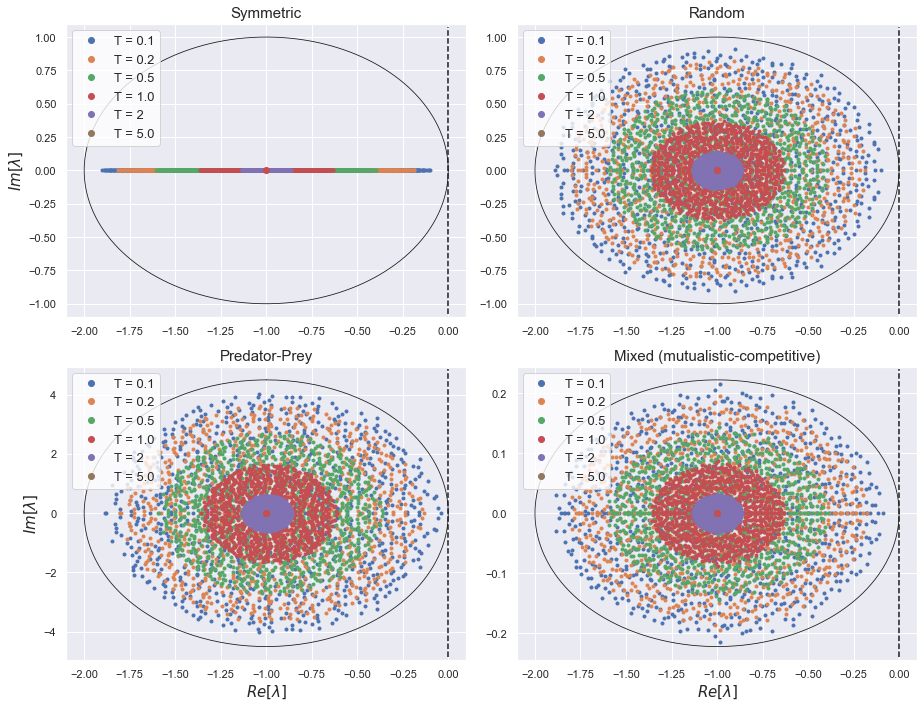

In [57]:
Tvec = [0.1,0.2,0.5,1.,2,5.]
sigma=0.05
Class.d=0
complexity = sigma*np.sqrt(Class.S*Class.C)
r = complexity
x = r*np.cos(theta)
y = r*np.sin(theta)

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
complexity = Class.sigma*np.sqrt(Class.S*Class.C)
Class.sym_matrix()
for T in Tvec:
    a = -1.
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl = comp_eig(A + b*Class.M)
    plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
    #evl = comp_eig_delay(0, Class.M, T, symm='yes')
    #plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
plt.plot(-1,0,'or')
plt.plot(np.sqrt(2)*complexity*x+a,np.sqrt(2)*complexity*y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,2)
Class.sigma = sigma
complexity = Class.sigma*np.sqrt(Class.S*Class.C)
Class.ran_matrix()
for T in Tvec:
    a = -1.
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl = comp_eig(A + b*Class.M)
    plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
    #evl = comp_eig_delay(0, Class.M, T, symm='no')
    #plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
plt.plot(-1,0,'or')
plt.plot(complexity*x+a,complexity*y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,3)
Class.sigma = sigma*np.pi/(np.pi-2)
complexity = Class.sigma*np.sqrt(Class.S*Class.C)
E = np.sqrt(2/np.pi)*Class.sigma
a = complexity*(1+(E/Class.sigma)**2)
b = complexity*(1-(E/Class.sigma)**2)
c = np.sqrt(a**2-b**2)
r1 = b/np.sqrt(1-(c/a*x)**2)
Class.pp_matrix()
for T in Tvec:
    a = -1.
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl = comp_eig(A + b*Class.M)
    plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
    #evl = comp_eig_delay(0, Class.M, T, symm='no')
    #plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
plt.plot(-1,0,'or')
plt.plot(r1*y+a,r1*x,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
complexity = Class.sigma*np.sqrt(Class.S*Class.C)
E = np.sqrt(2/np.pi)*Class.sigma
a = complexity*(1+(E/Class.sigma)**2)
b = complexity*(1-(E/Class.sigma)**2)
c = np.sqrt(a**2-b**2)
r1 = b/np.sqrt(1-(c/a*x)**2)
Class.mix_matrix()
for T in Tvec:
    a = -1.
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl = comp_eig(A + b*Class.M)
    plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
    #evl = comp_eig_delay(0, Class.M, T, symm='no')
    #plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
plt.plot(-1,0,'or')
plt.plot(r1*x+a,r1*y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

fig.tight_layout()
plt.show(fig)

In [58]:
#circle
theta = np.linspace(0, 2*np.pi, 1000)
r = 1
x = r*np.cos(theta)
y = r*np.sin(theta)

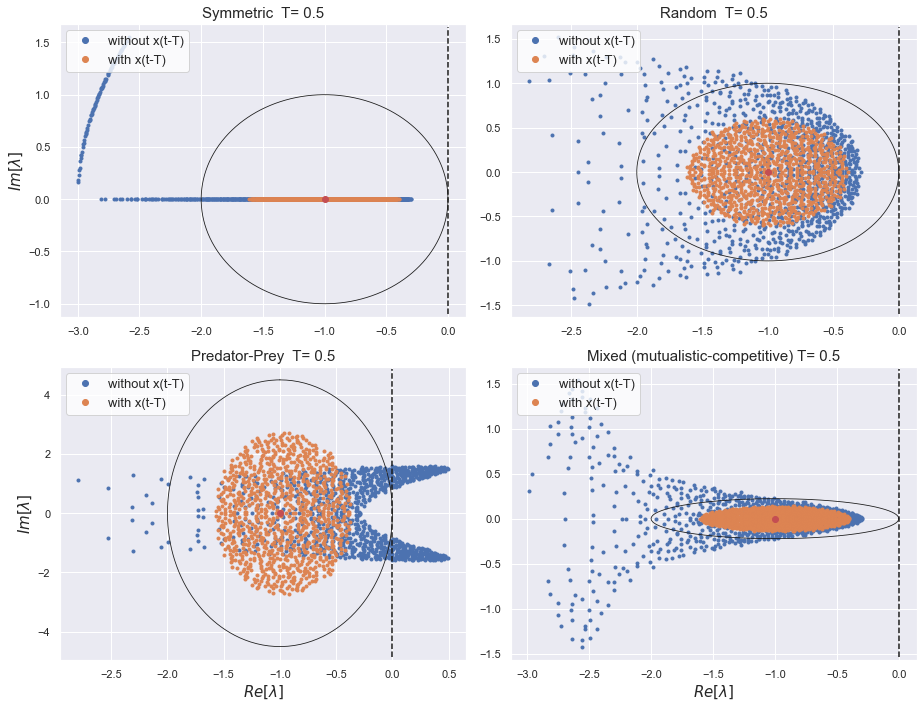

In [51]:
Tvec = [0.5]
Class.d = 0
sigma=0.05

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
complexity = Class.sigma*np.sqrt(Class.S*Class.C)
Class.sym_matrix()
for T in Tvec:
    a = -1.
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl = comp_eig(A + b*Class.M)
    evl1 = comp_eig_delay(A, b*Class.M, T, symm='yes')
    plt.plot(evl1.real, evl1.imag,'.',label=f'without x(t-T)')
    plt.plot(evl.real, evl.imag,'.',label=f'with x(t-T)')
    #evl = comp_eig_delay(0, Class.M, T, symm='yes')
    #plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
plt.plot(-1,0,'or')
plt.plot(np.sqrt(2)*complexity*x+a,np.sqrt(2)*complexity*y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title(f"Symmetric  T= {Tvec[0]}",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,2)
Class.sigma = sigma
complexity = Class.sigma*np.sqrt(Class.S*Class.C)
Class.ran_matrix()
for T in Tvec:
    a = -1.
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl = comp_eig(A + b*Class.M)
    evl1 = comp_eig_delay(A, b*Class.M, T, symm='no')
    plt.plot(evl1.real, evl1.imag,'.',label=f'without x(t-T)')
    plt.plot(evl.real, evl.imag,'.',label=f'with x(t-T)')
    #evl = comp_eig_delay(0, Class.M, T, symm='no')
    #plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
plt.plot(-1,0,'or')
plt.plot(complexity*x+a,complexity*y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title(f"Random  T= {Tvec[0]}",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,3)
Class.sigma = sigma*np.pi/(np.pi-2)
complexity = Class.sigma*np.sqrt(Class.S*Class.C)
E = np.sqrt(2/np.pi)*Class.sigma
a = complexity*(1+(E/Class.sigma)**2)
b = complexity*(1-(E/Class.sigma)**2)
c = np.sqrt(a**2-b**2)
r1 = b/np.sqrt(1-(c/a*x)**2)
Class.pp_matrix()
for T in Tvec:
    a = -1.
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl = comp_eig(A + b*Class.M)
    evl1 = comp_eig_delay(A, b*Class.M, T, symm='no')
    plt.plot(evl1.real, evl1.imag,'.',label=f'without x(t-T)')
    plt.plot(evl.real, evl.imag,'.',label=f'with x(t-T)')
    #evl = comp_eig_delay(0, Class.M, T, symm='no')
    #plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
plt.plot(-1,0,'or')
plt.plot(r1*y+a,r1*x,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title(f"Predator-Prey  T= {Tvec[0]}",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
complexity = Class.sigma*np.sqrt(Class.S*Class.C)
E = np.sqrt(2/np.pi)*Class.sigma
a = complexity*(1+(E/Class.sigma)**2)
b = complexity*(1-(E/Class.sigma)**2)
c = np.sqrt(a**2-b**2)
r1 = b/np.sqrt(1-(c/a*x)**2)
Class.mix_matrix()
for T in Tvec:
    a = -1.
    b = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl = comp_eig(A + b*Class.M)
    evl1 = comp_eig_delay(A, b*Class.M, T, symm='no')
    plt.plot(evl1.real, evl1.imag,'.',label=f'without x(t-T)')
    plt.plot(evl.real, evl.imag,'.',label=f'with x(t-T)')
    #evl = comp_eig_delay(0, Class.M, T, symm='no')
    #plt.plot(evl.real, evl.imag,'.',label=f'T = {T}')
plt.plot(-1,0,'or')
plt.plot(r1*x+a,r1*y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title(f"Mixed (mutualistic-competitive) T= {Tvec[0]}",fontsize=15)
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

fig.tight_layout()
plt.show(fig)

# Test with random $c_2$

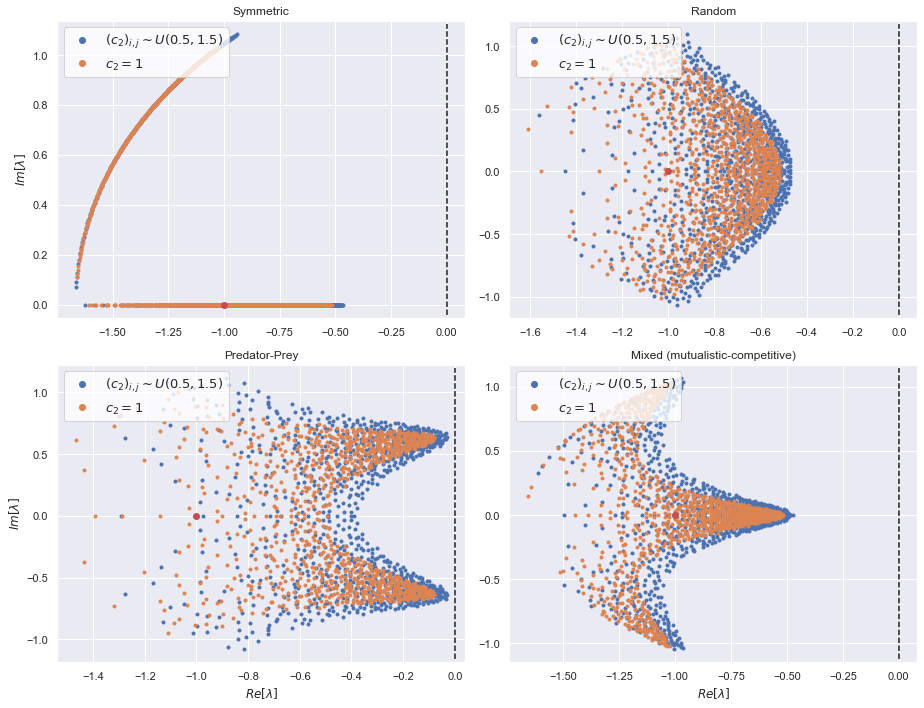

In [59]:
Tvec = [1.5]
sigma = 0.05
c2 = -rd.uniform(0.5,1.5,(Class.S,Class.S))

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = sigma/np.sqrt(2)
Class.sym_matrix()
for T in Tvec:
    a = -1.
    b = np.exp(c2*T)
    b1 = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl = comp_eig_delay(A, b*Class.M, T, symm='yes')
    plt.plot(evl.real, evl.imag,'.',label=r'$(c_2)_{i,j} \sim U(0.5,1.5)$')
    evl = comp_eig_delay(A, b1*Class.M, T, symm='yes')
    plt.plot(evl.real, evl.imag,'.',label=r'$c_2 = 1$ ')
plt.plot(-1,0,'or')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$')
plt.title("Symmetric")
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,2)
Class.sigma = sigma
Class.ran_matrix()
for T in Tvec:
    a = -1.
    b = np.exp(c2*T)
    b1 = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl = comp_eig_delay(A, b*Class.M, T, symm='no')
    plt.plot(evl.real, evl.imag,'.',label=r'$(c_2)_{i,j} \sim U(0.5,1.5)$')
    evl = comp_eig_delay(A, b1*Class.M, T, symm='no')
    plt.plot(evl.real, evl.imag,'.',label=r'$c_2 = 1$ ')
plt.plot(-1,0,'or')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random")
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,3)
Class.sigma = sigma*np.pi/(np.pi-2)
Class.pp_matrix()
for T in Tvec:
    a = -1.
    b = np.exp(c2*T)
    b1 = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl = comp_eig_delay(A, b*Class.M, T, symm='no')
    plt.plot(evl.real, evl.imag,'.',label=r'$(c_2)_{i,j} \sim U(0.5,1.5)$')
    evl = comp_eig_delay(A, b1*Class.M, T, symm='no')
    plt.plot(evl.real, evl.imag,'.',label=r'$c_2 = 1$ ')
plt.plot(-1,0,'or')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$')
plt.ylabel(f'$Im[\lambda]$')
plt.title("Predator-Prey")
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

plt.subplot(2,2,4)
Class.sigma = sigma*np.pi/(np.pi+2)
Class.mix_matrix()
for T in Tvec:
    a = -1.
    b = np.exp(c2*T)
    b1 = np.exp(a*T)
    A = a*np.eye(Class.S)
    evl = comp_eig_delay(A, b*Class.M, T, symm='no')
    plt.plot(evl.real, evl.imag,'.',label=r'$(c_2)_{i,j} \sim U(0.5,1.5)$')
    evl = comp_eig_delay(A, b1*Class.M, T, symm='no')
    plt.plot(evl.real, evl.imag,'.',label=r'$c_2 = 1$ ')
plt.plot(-1,0,'or')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$')
plt.title("Mixed (mutualistic-competitive)")
plt.legend(fontsize=13,markerscale=2,loc='upper left',facecolor='w')

fig.tight_layout()
plt.show(fig)

# A, B upper triangular

In [60]:
S = 1000       #species - shape matrix
C = 0.4        #connectance
d = 1          #diagonal elements
mu = 0         #mean random coefficients
sigma = 0.05    #sigma random coefficients

complexity = sigma*np.sqrt(S*C)
Class = RMG(S,C,d,mu,sigma)

In [61]:
Tvec = [0.2,0.5,1.,2.]
a = np.linspace(-2,2,200)

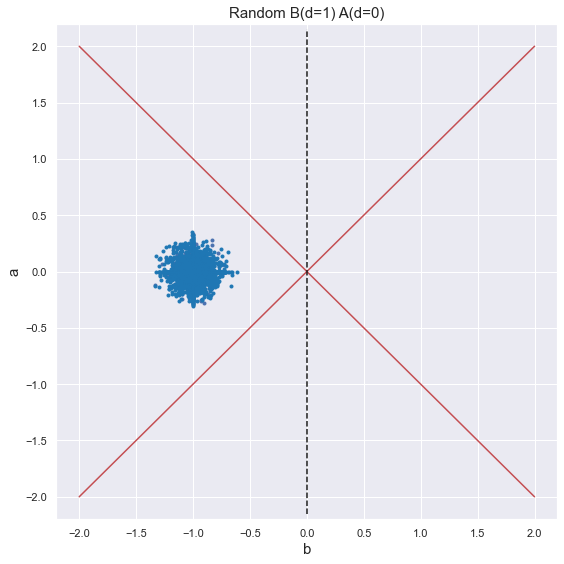

In [62]:
Class.d = 1
num=10

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(8,8)

Class.sigma = 0.1
Class.d = 0
Class.ran_matrix()
A = Class.M
Class.d = 1
Class.ran_matrix()
B = Class.M
evlA = np.diag(A)
evlB = np.diag(B)
plt.plot(evlB, evlA,'.')
for j in range(num):
    Class.d = 0
    Class.ran_matrix()
    A = Class.M
    Class.d = 1
    Class.ran_matrix()
    B = Class.M
    evlA = np.diag(A)
    evlB = np.diag(B)
    plt.plot(evlB, evlA,'.',color=color[0])
plt.plot(a,-a,'r-')
plt.plot(a,a,'r-')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random B(d=1) A(d=0)",fontsize=15)
plt.xlabel('b',fontsize=15)
plt.ylabel('a',fontsize=15)

fig.tight_layout()
plt.show(fig)

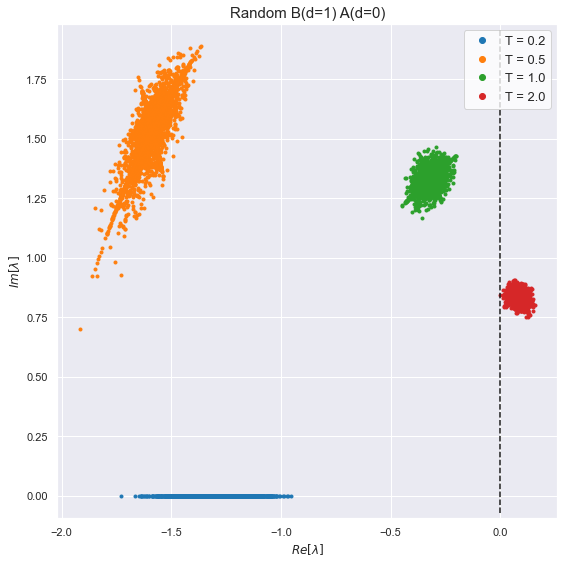

In [63]:
num=10

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(8,8)

Class.sigma = sigma
Class.d = 0
Class.ran_matrix()
A = Class.M
Class.d = 1
Class.ran_matrix()
B = Class.M
for j,T in enumerate(Tvec):
    evlA = np.diag(A)
    evlB = np.diag(B)
    evl  = lambda_funct (evlA,evlB,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.d = 0
        Class.ran_matrix()
        A = Class.M
        Class.d = 1
        Class.ran_matrix()
        B = Class.M
        evlA = np.diag(A)
        evlB = np.diag(B)
        evl  = lambda_funct (evlA,evlB,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])       

plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random B(d=1) A(d=0)",fontsize=15)
plt.xlabel(f'$Re[\lambda]$')
plt.ylabel(f'$Im[\lambda]$')
plt.legend(fontsize=13,markerscale=2,loc='upper right',facecolor='w')

fig.tight_layout()
plt.show(fig)

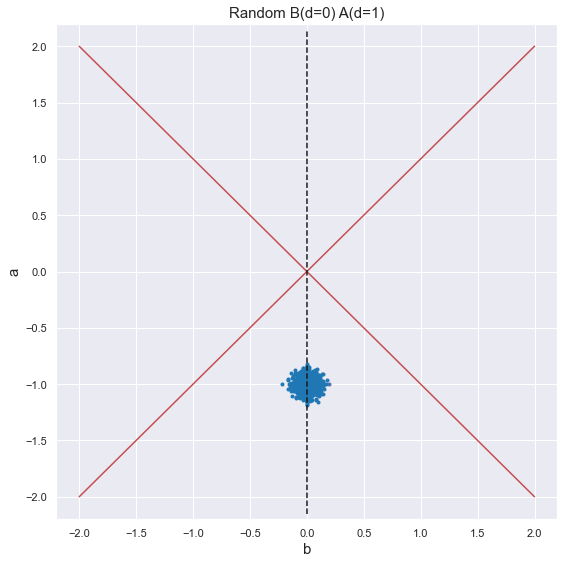

In [64]:
Class.d = 1
num=10

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(8,8)

Class.sigma = sigma
Class.d = 1
Class.ran_matrix()
A = Class.M
Class.d = 0
Class.ran_matrix()
B = Class.M
evlA = np.diag(A)
evlB = np.diag(B)
plt.plot(evlB, evlA,'.')
for j in range(num):
    Class.d = 1
    Class.ran_matrix()
    A = Class.M
    Class.d = 0
    Class.ran_matrix()
    B = Class.M
    evlA = np.diag(A)
    evlB = np.diag(B)
    plt.plot(evlB, evlA,'.',color=color[0])
plt.plot(a,-a,'r-')
plt.plot(a,a,'r-')
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random B(d=0) A(d=1)",fontsize=15)
plt.xlabel('b',fontsize=15)
plt.ylabel('a',fontsize=15)

fig.tight_layout()
plt.show(fig)

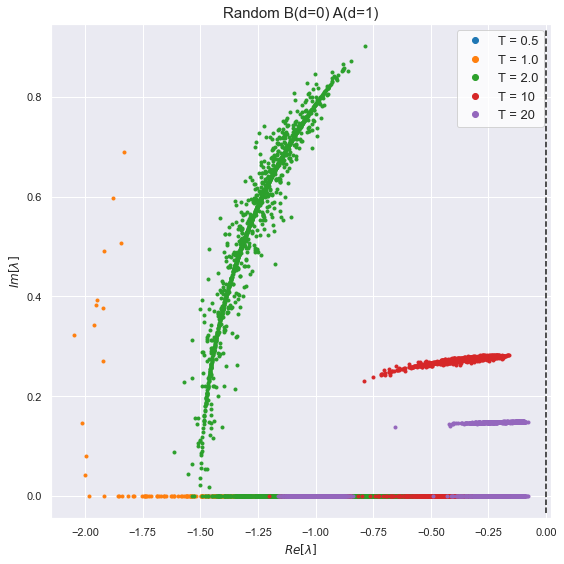

In [65]:
Tvec = [0.5,1.,2.,10,20]
num=10

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(8,8)

Class.sigma = sigma
Class.d = 1
Class.ran_matrix()
A = Class.M
Class.d = 0
Class.ran_matrix()
B = Class.M
for j,T in enumerate(Tvec):
    evlA = np.diag(A)
    evlB = np.diag(B)
    evl  = lambda_funct (evlA,evlB,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.d = 1
        Class.ran_matrix()
        A = Class.M
        Class.d = 0
        Class.ran_matrix()
        B = Class.M
        evlA = np.diag(A)
        evlB = np.diag(B)
        evl  = lambda_funct (evlA,evlB,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])       

plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random B(d=0) A(d=1)",fontsize=15)
plt.xlabel(f'$Re[\lambda]$')
plt.ylabel(f'$Im[\lambda]$')
plt.legend(fontsize=13,markerscale=2,loc='upper right',facecolor='w')

fig.tight_layout()
plt.show(fig)

# Verify if trajectories of upper triangular converge

In [9]:
from ddeint import ddeint

def model(Y, t, T, A, B):
    return A@Y(t) + B@Y(t - T)

In [20]:
def Show_Trajectory(A,B,g,T,time):
    y = ddeint(model, g, time, fargs=(T,A,B,))
    
    fig, ax = plt.subplots(sharey=True)
    fig = plt.gcf()
    fig.set_size_inches(14,5)
    fig.tight_layout()
    
    plt.subplot(1,2,1)
    evlA = np.diag(A)
    evlB = np.diag(B)
    evl  = lambda_funct (evlA,evlB,T)
    plt.plot(evl.real, evl.imag,'.')
    plt.axvline(0,0.01,0.99,ls='--',c='k')
    plt.xlabel(f'$Re[\lambda]$')
    plt.ylabel(f'$Im[\lambda]$')
    plt.title(f"Eigenvalues upper triangular R.M. with T = {T}",fontsize=12)
    plt.grid()
    
    plt.subplot(1,2,2)
    nn = 0
    for i in range(A.shape[0]):
        if np.mean(abs(y[-int(len(time)/10):,i]))>10:
            plt.plot(time,y[:,i],'r-',linewidth=0.8)
            nn += 1/A.shape[0]*100
        else:
            plt.plot(time,y[:,i],'b-',linewidth=0.4)
    plt.plot(time,np.exp(max(evl.real)*time),'k-')  
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylim(bottom=10**(-10))
    plt.title(f'Trajectories with T={T} ({np.round(nn,1)}% of them are divergent)',fontsize=12)
    #plt.xlabel('t',fontsize=12)
    #plt.ylabel(f'$X_i (t)$',fontsize=12)
    plt.grid()

In [21]:
Class.S = 100
Class.C = 1
Class.sigma = 0.1

dt = 0.2
tfin = 200
time = np.linspace(0, tfin, int(tfin/dt))
T=1

g = lambda t: 0.1*np.ones(Class.S)

In [22]:
Class.d = 1
Class.ran_matrix()
A = Class.M
A1 = np.triu(A, k=0)
Class.d = 0
Class.ran_matrix()
B = Class.M
B1 = np.triu(B, k=0)

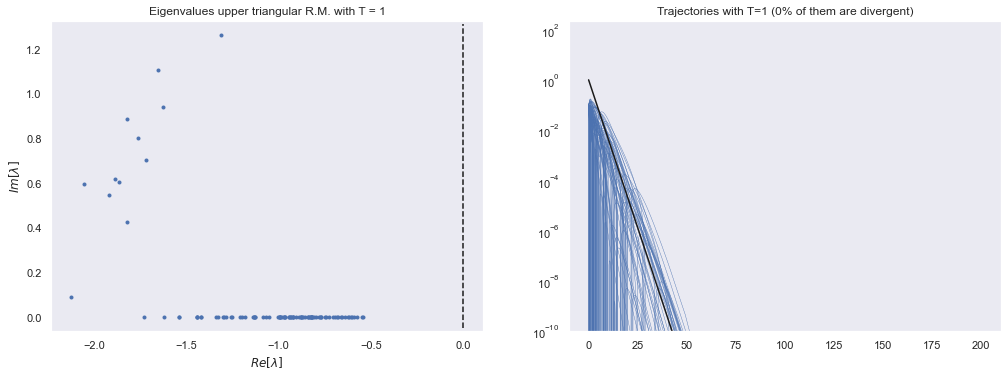

In [23]:
Show_Trajectory(A1,B1,g,T,time)
plt.show()

In [25]:
A2 = np.copy(A)
A2[np.triu_indices(A.shape[0], k = 1)] = 1
A2 = np.triu(A2, k=0)
B2 = np.copy(B)
B2[np.triu_indices(B.shape[0], k = 1)] = 1
B2 = np.triu(B2, k=0)

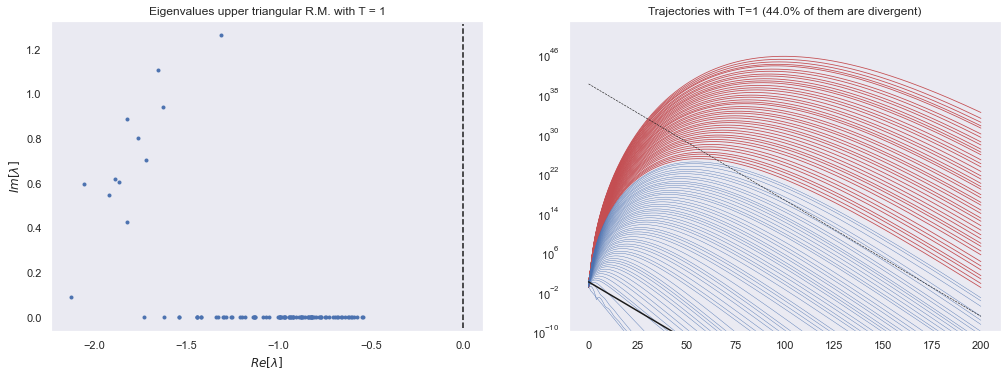

In [27]:
Show_Trajectory(A2,B2,g,T,time)
evlA = np.diag(A2)
evlB = np.diag(B2)
evl  = lambda_funct (evlA,evlB,T)
plt.plot(time,10**40*np.exp(max(evl.real)*time),'k--',linewidth=0.6) 
plt.show()

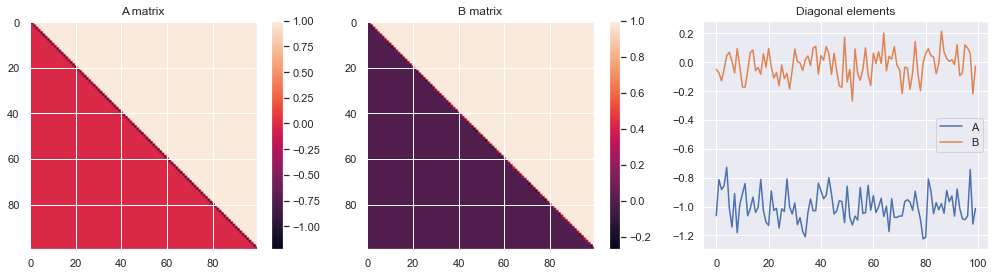

In [58]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(14,4)

plt.subplot(1,3,1)
plt.imshow(A2)
plt.colorbar()
plt.title('A matrix')
plt.subplot(1,3,2)
plt.imshow(B2)
plt.colorbar()
plt.title('B matrix')
plt.subplot(1,3,3)
plt.plot(np.diag(A2),label='A')
plt.plot(np.diag(B2),label='B')
plt.title('Diagonal elements')
plt.legend()

fig.tight_layout()
plt.show(fig)